In [682]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
sns.set_style('whitegrid')
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.figsize'] = (12, 8)
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 400)
import warnings
warnings.filterwarnings('ignore')
import datetime
import pandas_profiling as pp
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.base import clone
from xgboost import XGBRegressor
# from catboost import CatBoostRegressor
import lightgbm as lgb

In [683]:
train = pd.read_csv('/content/drive/Shareddrives/utshabkg/ML_Competition-AND-Practice/Competition/HackerEarth Fast, Furious and Insured/dataset/processed_data/train_aug.csv')
test0 = pd.read_csv('/content/drive/Shareddrives/utshabkg/ML_Competition-AND-Practice/Competition/HackerEarth Fast, Furious and Insured/dataset/test.csv')
test0.head()

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage
0,img_4538519.jpg,B,23600,590.00,2025-04-12,5978.00
1,img_7766002.jpg,C,28300,707.50,2028-08-24,7153.00
2,img_4637390.jpg,AC,43700,1092.50,2023-11-28,11003.00
3,img_4516108.jpg,BB,46100,1152.50,2028-02-04,11603.00
4,img_4517008.jpg,BB,40700,1017.50,2022-01-03,10253.00


In [684]:
test_result = pd.read_csv('/content/drive/Shareddrives/utshabkg/ML_Competition-AND-Practice/Competition/HackerEarth Fast, Furious and Insured/test_result.csv')
test_result.head()

,Image_path,Condition
0,img_4511084.jpg,0
1,img_4511787.jpg,1
2,img_4512558.jpg,0
3,img_4513036.jpg,1
4,img_4513264.jpg,0


In [685]:
test = pd.merge(test0, test_result, on='Image_path', sort=False)
test

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition
0,img_4538519.jpg,B,23600,590.00,2025-04-12,5978.00,1
1,img_7766002.jpg,C,28300,707.50,2028-08-24,7153.00,1
2,img_4637390.jpg,AC,43700,1092.50,2023-11-28,11003.00,1
3,img_4516108.jpg,BB,46100,1152.50,2028-02-04,11603.00,1
4,img_4517008.jpg,BB,40700,1017.50,2022-01-03,10253.00,1
...,...,...,...,...,...,...,...
595,img_7766518.jpg,B,30900,772.50,2024-10-23,7803.00,1
596,img_4535713.jpg,O,51300,1282.50,2025-02-21,12903.00,1
597,img_4511787.jpg,BQ,27000,675.00,2023-07-13,23527.68,1
598,img_4517592.jpg,AA,42600,1065.00,2024-05-05,10728.00,1


# EDA

In [686]:
len(test[test.Condition==0])

35

In [687]:
# check for duplicates
print(train.shape)
train.drop_duplicates(inplace=True)
print(train.shape)

(7800, 8)
(7800, 8)


In [688]:
# correlation heatmap for all features
def plot_correlation(data):
    corr = data.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask = mask, annot=True)
    plt.show()

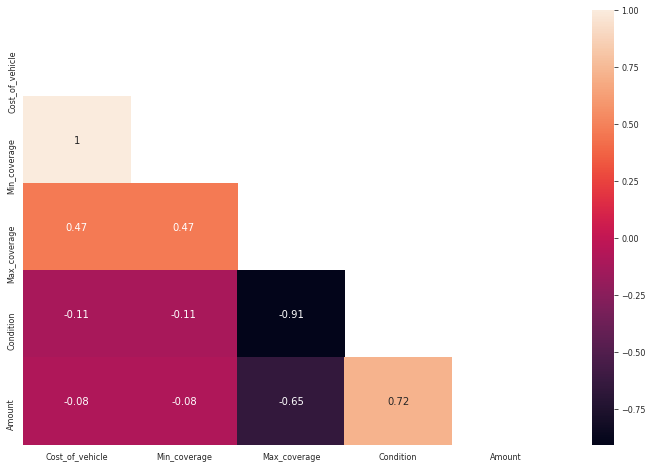

In [689]:
plot_correlation(train)

In [690]:
# select numerical and categorical features
def divideFeatures(df):
    numerical_features = df.select_dtypes(include=[np.number])
    categorical_features = df.select_dtypes(include=[np.object])
    return numerical_features, categorical_features

In [691]:
cont_features, cat_features = divideFeatures(train)
cat_features

,Image_path,Insurance_company,Expiry_date
0,0000.jpg,BQ,2026-12-03
1,0001.jpg,BQ,2025-07-10
2,0002.jpg,A,2022-08-11
3,0003.jpg,A,2022-08-02
4,0004.jpg,AC,2026-05-01
...,...,...,...
7795,1352_3797.jpg,BC,2028-01-11
7796,1352_3798.jpg,BC,2028-01-11
7797,1352_3799.jpg,BC,2028-01-11
7798,1352_3800.jpg,BC,2028-01-11


In [692]:
cont_features

,Cost_of_vehicle,Min_coverage,Max_coverage,Condition,Amount
0,41500.00,1037.50,36142.68,0,0.00
1,50700.00,1267.50,12753.00,1,6194.00
2,49500.00,1237.50,43102.68,0,0.00
3,33500.00,837.50,8453.00,1,7699.00
4,27600.00,690.00,6978.00,1,8849.00
...,...,...,...,...,...
7795,45300.00,1132.50,39448.68,0,0.00
7796,45300.00,1132.50,39448.68,0,0.00
7797,45300.00,1132.50,39448.68,0,0.00
7798,45300.00,1132.50,39448.68,0,0.00


In [693]:
# plot sample skewed feature
def plot_skewed_feature(data):
    plt.figure(figsize=(10,4))
    sns.distplot(data['Amount'])
    plt.show()

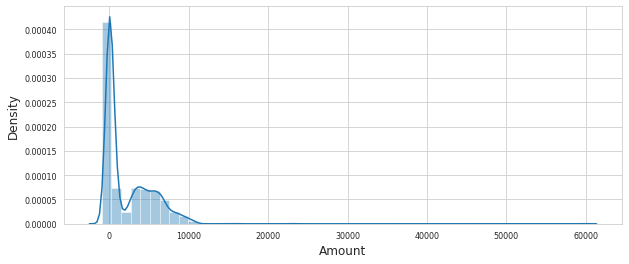

In [694]:
plot_skewed_feature(train)

In [695]:
skewed_features = cont_features.apply(lambda x: x.skew()).sort_values(ascending=False)
skewed_features

Amount             3.41
Max_coverage       0.35
Condition          0.00
Cost_of_vehicle   -0.07
Min_coverage      -0.07
dtype: float64

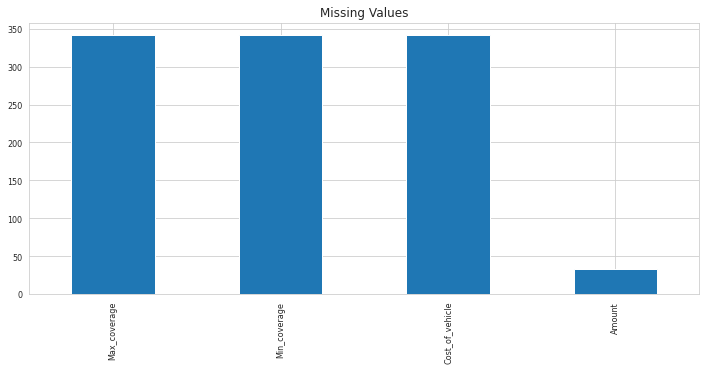

In [696]:
# plot missing values

def calc_missing(data):
    missing = data.isna().sum().sort_values(ascending=False)
    missing = missing[missing != 0]
    missing_perc = missing/data.shape[0]*100
    return missing, missing_perc

if train.isna().any().sum()>0:
    missing, missing_perc = calc_missing(data=train)
    missing.plot(kind='bar',figsize=(12,5))
    plt.title('Missing Values')
    plt.show()
else:
    print("No Missing Values")

In [697]:
if test.isna().any().sum()>0:
    missing, missing_perc = calc_missing(data=test)
    missing.plot(kind='bar',figsize=(12,5))
    plt.title('Missing Values')
    plt.show()
else:
    print("No Missing Values")

No Missing Values


In [698]:
# remove all columns having no values
train.dropna(axis=1, how="all", inplace=True)
train.dropna(axis=0, how="all", inplace=True)
train.shape

(7800, 8)

### Comparing train and test data And Outlier handling

In [699]:
# function to create histogram, Q-Q plot and boxplot

def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 5, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 5, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 5, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    
    plt.show()

In [700]:
def comparing_train_and_test_feature(df,df_test,col):
    fig = plt.figure(figsize=(16,10))
    ax0 = fig.add_subplot(1,2,1)
    ax1 = fig.add_subplot(1,2,2)
    df[col].plot(kind='kde',ax=ax0)
    df_test[col].plot(kind='kde',ax=ax1)
    ax0.set_xlabel(col)
    ax1.set_xlabel(col)
    ax0.set_title("Density plot of " + str(col) + " of training set")
    ax1.set_title("Density plot of " + str(col) + " of testing set")
    plt.show()

In [701]:
train.columns

Index(['Image_path', 'Insurance_company', 'Cost_of_vehicle', 'Min_coverage', 'Expiry_date', 'Max_coverage', 'Condition', 'Amount'], dtype='object')

### Cost_of_vehicle

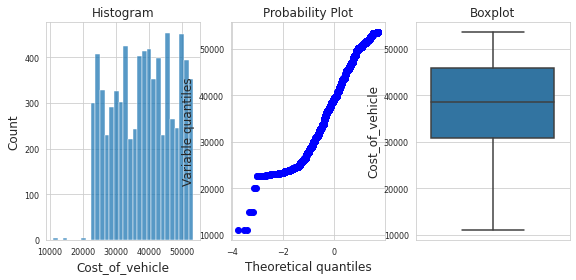

In [702]:
diagnostic_plots(train, 'Cost_of_vehicle')

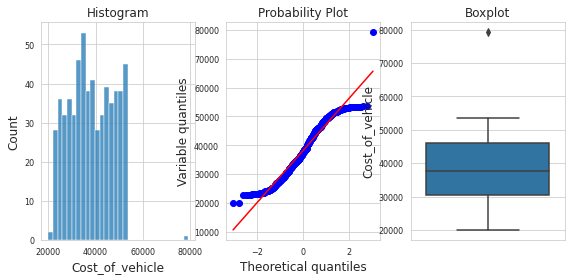

In [703]:
diagnostic_plots(test, 'Cost_of_vehicle')

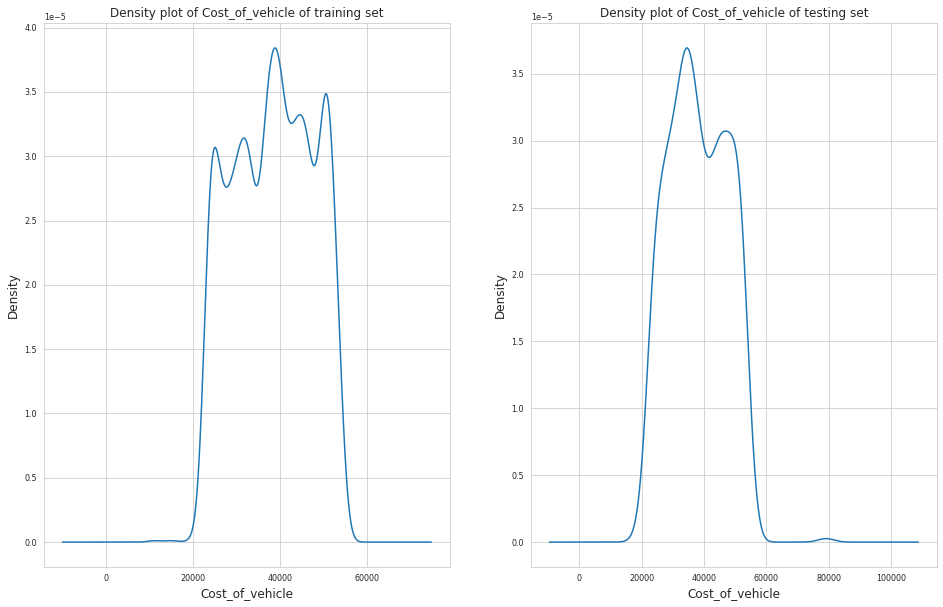

In [704]:
## Comparing the density plot of features in training and testing set
comparing_train_and_test_feature(train, test, 'Cost_of_vehicle')
## Distribution of Feature Cost_of_vehicle of training and testing dataset are very similar

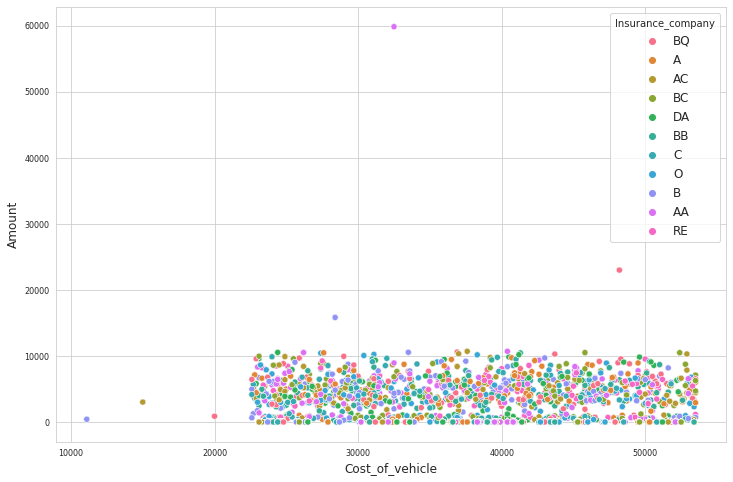

In [705]:
sns.scatterplot(x='Cost_of_vehicle', y='Amount', hue='Insurance_company', data=train)

### Min_coverage

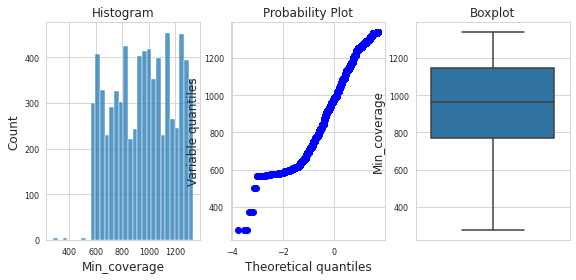

In [706]:
diagnostic_plots(train, 'Min_coverage')

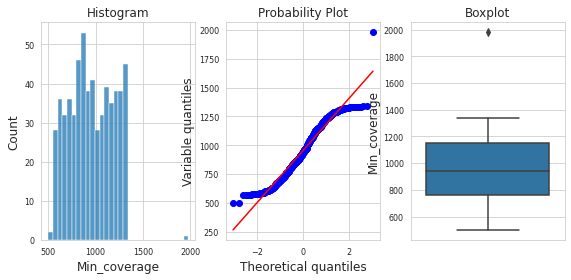

In [707]:
diagnostic_plots(test, 'Min_coverage')

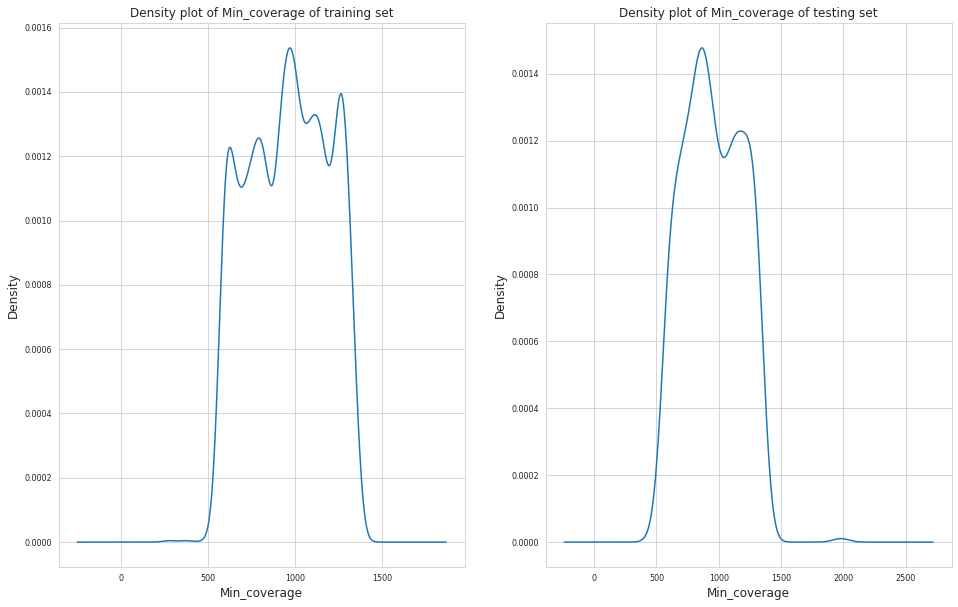

In [708]:
## Comparing the density plot of features in training and testing set
comparing_train_and_test_feature(train, test, 'Min_coverage')
## Distribution of Feature Min_coverage of training and testing dataset are very similar

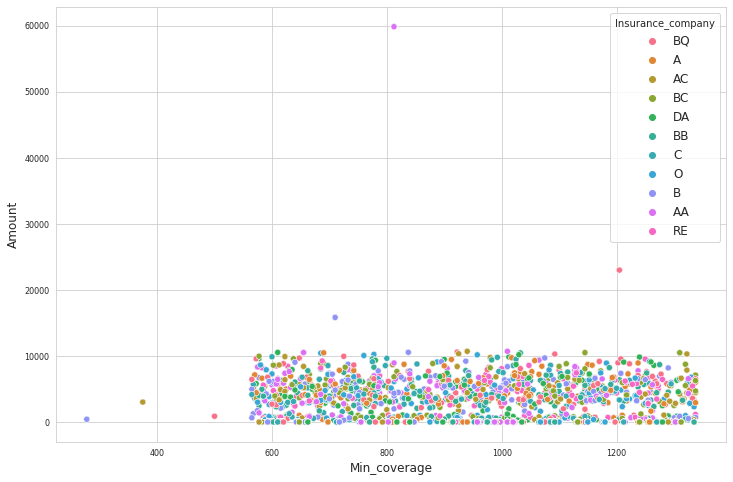

In [709]:
sns.scatterplot(x='Min_coverage', y='Amount', hue='Insurance_company', data=train)

### Max_coverage

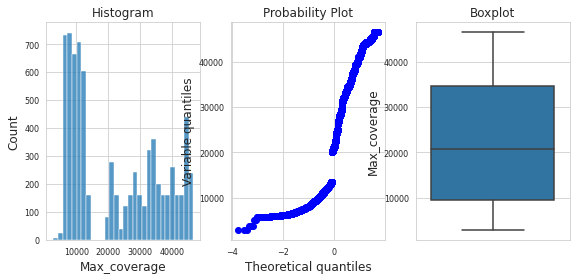

In [710]:
diagnostic_plots(train, 'Max_coverage')

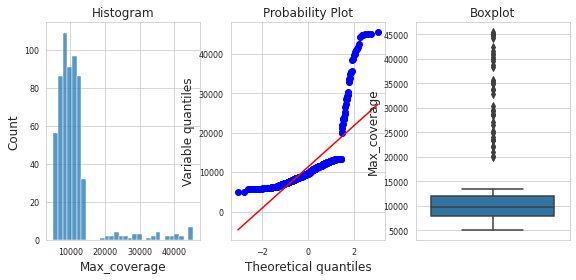

In [711]:
diagnostic_plots(test, 'Max_coverage')

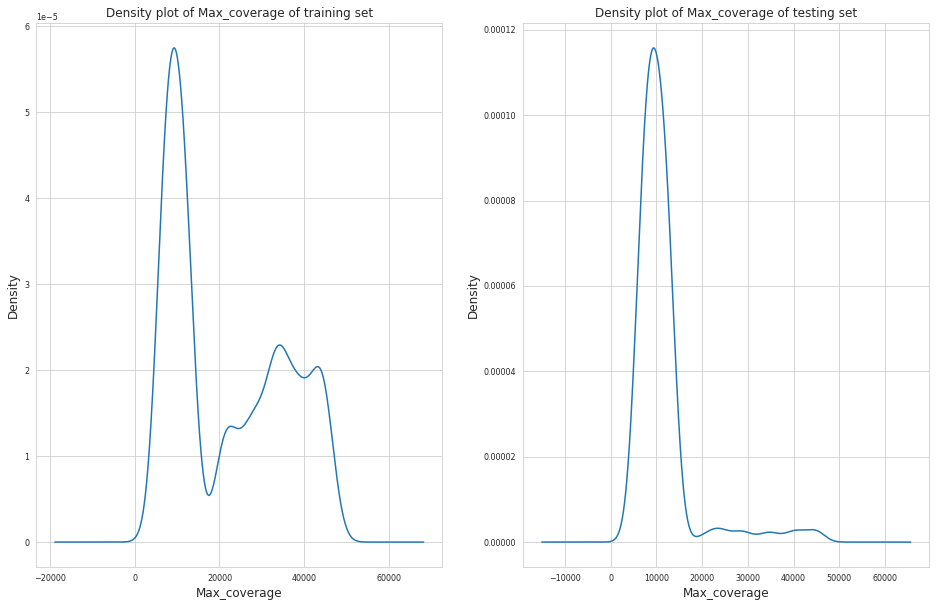

In [712]:
## Comparing the density plot of features in training and testing set
comparing_train_and_test_feature(train, test, 'Max_coverage')
## Distribution of Feature Max_coverage of training and testing dataset are very similar

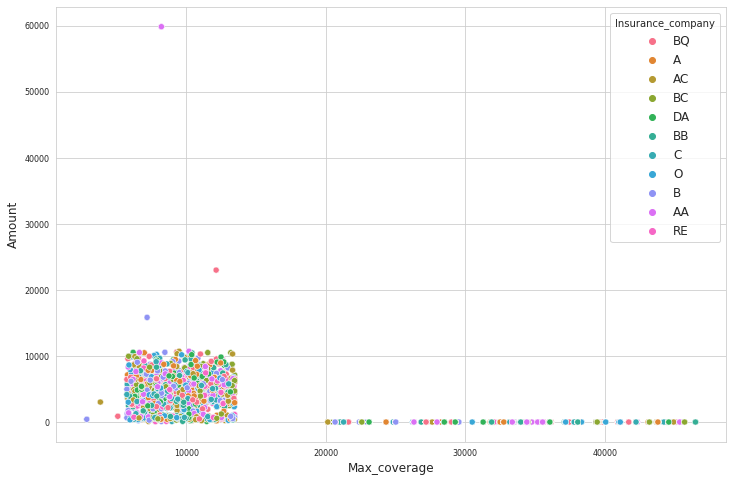

In [713]:
sns.scatterplot(x='Max_coverage', y='Amount', hue='Insurance_company', data=train)

### Condition

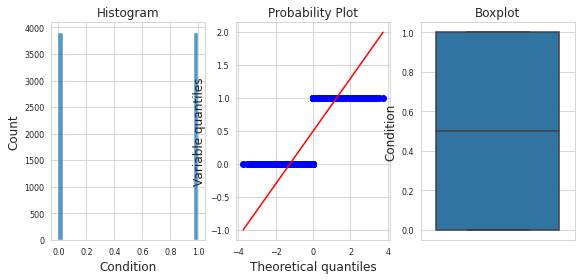

In [714]:
diagnostic_plots(train, 'Condition')

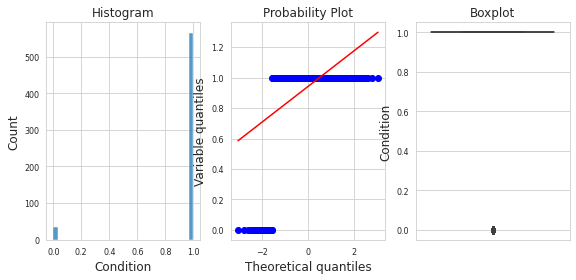

In [715]:
diagnostic_plots(test, 'Condition')

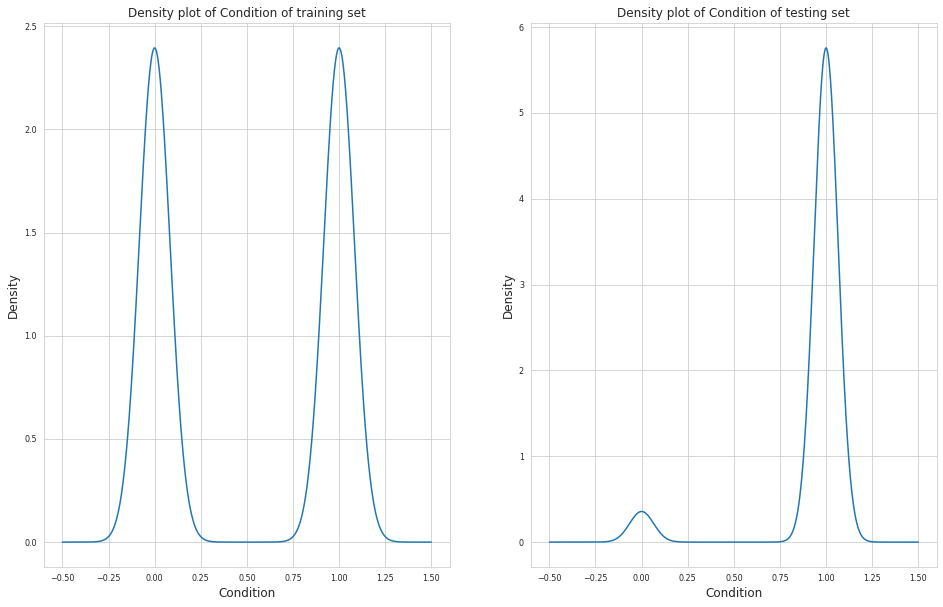

In [716]:
## Comparing the density plot of features in training and testing set
comparing_train_and_test_feature(train, test, 'Condition')
## Distribution of Feature Condition of training and testing dataset are very similar

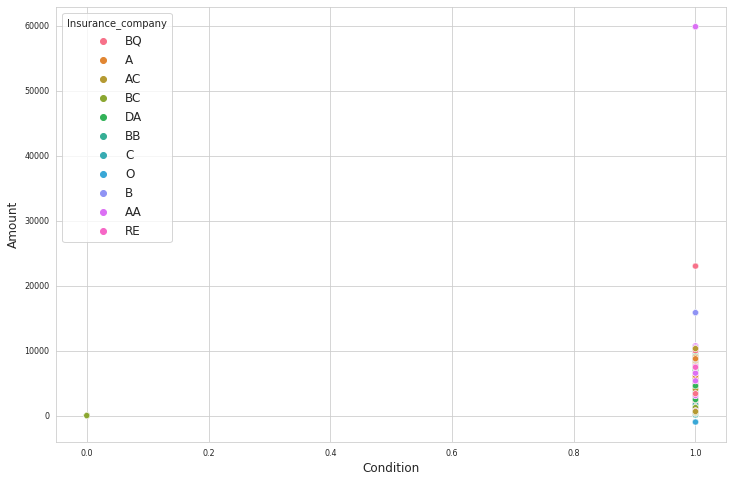

In [717]:
sns.scatterplot(x='Condition', y='Amount', hue='Insurance_company', data=train)

# Missing Values

In [718]:
def fillNan(df, col, value):
    df[col].fillna(value, inplace=True)

In [719]:
train.isnull().sum()

Image_path             0
Insurance_company      0
Cost_of_vehicle      341
Min_coverage         341
Expiry_date            0
Max_coverage         341
Condition              0
Amount                33
dtype: int64

In [720]:
test.isnull().sum()

Image_path           0
Insurance_company    0
Cost_of_vehicle      0
Min_coverage         0
Expiry_date          0
Max_coverage         0
Condition            0
dtype: int64

In [721]:
fillNan(train, 'Cost_of_vehicle', train['Cost_of_vehicle'].mean())
fillNan(train, 'Min_coverage', train['Min_coverage'].mean())
fillNan(train, 'Max_coverage', train['Max_coverage'].mean())
fillNan(train, 'Amount', train['Amount'].mean())

In [722]:
train.isnull().sum()

Image_path           0
Insurance_company    0
Cost_of_vehicle      0
Min_coverage         0
Expiry_date          0
Max_coverage         0
Condition            0
Amount               0
dtype: int64

# Encoding

In [723]:
# label encoding
def mapFeature(data, f, data_test=None):
    feat = data[f].unique()
    feat_idx = [x for x in range(len(feat))]

    data[f].replace(feat, feat_idx, inplace=True)
    if data_test is not None:
        data_test[f].replace(feat, feat_idx, inplace=True)

In [724]:
cat_features.columns

Index(['Image_path', 'Insurance_company', 'Expiry_date'], dtype='object')

In [725]:
mapFeature(train, 'Insurance_company', test)
test.head()

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition
0,img_4538519.jpg,8,23600,590.00,2025-04-12,5978.00,1
1,img_7766002.jpg,6,28300,707.50,2028-08-24,7153.00,1
2,img_4637390.jpg,2,43700,1092.50,2023-11-28,11003.00,1
3,img_4516108.jpg,5,46100,1152.50,2028-02-04,11603.00,1
4,img_4517008.jpg,5,40700,1017.50,2022-01-03,10253.00,1


In [726]:
# create dummy features
custom_feat = ['Insurance_company']
for feat in cat_features.columns:
    if len(train[feat].unique()) > 2 and feat in custom_feat:
        dummyVars = pd.get_dummies(train[feat], drop_first=True, prefix=feat+"_")
        train = pd.concat([train, dummyVars], axis=1)
        train.drop(feat, axis=1, inplace=True)
print(train.shape)

train.head()

(7800, 17)


,Image_path,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount,Insurance_company__1,Insurance_company__2,Insurance_company__3,Insurance_company__4,Insurance_company__5,Insurance_company__6,Insurance_company__7,Insurance_company__8,Insurance_company__9,Insurance_company__10
0,0000.jpg,41500.00,1037.50,2026-12-03,36142.68,0,0.00,0,0,0,0,0,0,0,0,0,0
1,0001.jpg,50700.00,1267.50,2025-07-10,12753.00,1,6194.00,0,0,0,0,0,0,0,0,0,0
2,0002.jpg,49500.00,1237.50,2022-08-11,43102.68,0,0.00,1,0,0,0,0,0,0,0,0,0
3,0003.jpg,33500.00,837.50,2022-08-02,8453.00,1,7699.00,1,0,0,0,0,0,0,0,0,0
4,0004.jpg,27600.00,690.00,2026-05-01,6978.00,1,8849.00,0,1,0,0,0,0,0,0,0,0


In [727]:
# create dummy features
custom_feat = ['Insurance_company']
for feat in cat_features.columns:
    if len(test[feat].unique()) > 2 and feat in custom_feat:
        dummyVars = pd.get_dummies(test[feat], drop_first=True, prefix=feat+"_")
        test = pd.concat([test, dummyVars], axis=1)
        test.drop(feat, axis=1, inplace=True)

test.head()

,Image_path,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Insurance_company__1,Insurance_company__2,Insurance_company__3,Insurance_company__4,Insurance_company__5,Insurance_company__6,Insurance_company__7,Insurance_company__8,Insurance_company__9,Insurance_company__10
0,img_4538519.jpg,23600,590.00,2025-04-12,5978.00,1,0,0,0,0,0,0,0,1,0,0
1,img_7766002.jpg,28300,707.50,2028-08-24,7153.00,1,0,0,0,0,0,1,0,0,0,0
2,img_4637390.jpg,43700,1092.50,2023-11-28,11003.00,1,0,1,0,0,0,0,0,0,0,0
3,img_4516108.jpg,46100,1152.50,2028-02-04,11603.00,1,0,0,0,0,1,0,0,0,0,0
4,img_4517008.jpg,40700,1017.50,2022-01-03,10253.00,1,0,0,0,0,1,0,0,0,0,0


In [728]:
train.shape, test.shape

((7800, 17), (600, 16))

# Make Features! :D

In [729]:
train['Expiry_date'] = pd.to_datetime(train['Expiry_date'])
test['Expiry_date'] = pd.to_datetime(test['Expiry_date'])

train['year'] = train['Expiry_date'].dt.year
test['year'] = test['Expiry_date'].dt.year

train['month'] = train['Expiry_date'].dt.month
test['month'] = test['Expiry_date'].dt.month

train['day'] = train['Expiry_date'].dt.day
test['day'] = test['Expiry_date'].dt.day

train['dayofweek'] = train['Expiry_date'].dt.dayofweek
test['dayofweek'] = test['Expiry_date'].dt.dayofweek

train['quarter'] = train['Expiry_date'].dt.quarter
test['quarter'] = test['Expiry_date'].dt.quarter

In [730]:
train.drop(['Image_path', 'Expiry_date'], inplace=True, axis=1)
submission = pd.DataFrame(data=test['Image_path'])
submission['Condition'] = test.Condition
test.drop(['Image_path', 'Expiry_date'], inplace=True, axis=1)
train.head()

,Cost_of_vehicle,Min_coverage,Max_coverage,Condition,Amount,Insurance_company__1,Insurance_company__2,Insurance_company__3,Insurance_company__4,Insurance_company__5,Insurance_company__6,Insurance_company__7,Insurance_company__8,Insurance_company__9,Insurance_company__10,year,month,day,dayofweek,quarter
0,41500.00,1037.50,36142.68,0,0.00,0,0,0,0,0,0,0,0,0,0,2026,12,3,3,4
1,50700.00,1267.50,12753.00,1,6194.00,0,0,0,0,0,0,0,0,0,0,2025,7,10,3,3
2,49500.00,1237.50,43102.68,0,0.00,1,0,0,0,0,0,0,0,0,0,2022,8,11,3,3
3,33500.00,837.50,8453.00,1,7699.00,1,0,0,0,0,0,0,0,0,0,2022,8,2,1,3
4,27600.00,690.00,6978.00,1,8849.00,0,1,0,0,0,0,0,0,0,0,2026,5,1,4,2


# Regressors

In [731]:
# shuffle samples
df_shuffle = train.sample(frac=1, random_state=42).reset_index(drop=True)

df_y = df_shuffle.pop('Amount')
df_X = df_shuffle

# split into train dev and test
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, train_size=0.8, random_state=42)
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 6240 records out of 7800 which is 80%
Test set has 1560 records out of 7800 which is 20%


In [732]:
scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# scale test data with transform()
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

# view sample data
X_train.describe()

,Cost_of_vehicle,Min_coverage,Max_coverage,Condition,Insurance_company__1,Insurance_company__2,Insurance_company__3,Insurance_company__4,Insurance_company__5,Insurance_company__6,Insurance_company__7,Insurance_company__8,Insurance_company__9,Insurance_company__10,year,month,day,dayofweek,quarter
count,6240.00,6240.00,6240.00,6240.00,6240.00,6240.00,6240.00,6240.00,6240.00,6240.00,6240.00,6240.00,6240.00,6240.00,6240.00,6240.00,6240.00,6240.00,6240.00
mean,-0.00,-0.00,0.03,-0.50,0.10,0.07,0.09,0.09,0.09,0.09,0.09,0.10,0.10,0.07,-0.05,-0.05,0.05,0.00,-0.15
std,0.61,0.61,0.54,0.50,0.30,0.26,0.29,0.28,0.29,0.29,0.29,0.30,0.31,0.25,0.53,0.51,0.56,0.49,0.38
min,-1.91,-1.91,-0.74,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,-0.86,-0.87,-0.75,-0.67
25%,-0.51,-0.51,-0.47,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.50,-0.57,-0.47,-0.50,-0.67
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.49,0.49,0.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.43,0.53,0.50,0.33
max,1.06,1.06,1.02,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.75,0.71,1.13,0.75,0.33


### XGBoost

In [733]:
regressor1 = XGBRegressor(n_estimators=500,max_depth=5,booster='gbtree',n_jobs=-1,learning_rate=0.1,reg_lambda=0.01,reg_alpha=0.3)

### LightGBM

In [734]:
regressor2 = lgb.LGBMRegressor(objective='mse', seed=8798, num_threads=1, learning_rate=0.1, 
                               max_depth=5, n_estimators=750, num_leaves=70, reg_alpha=0.001, reg_lambda=0.003)

### CatBoost

In [735]:
! pip install catboost
from catboost import CatBoostRegressor
regressor3 = CatBoostRegressor()

### GradientBoosting

In [736]:
regressor4 = GradientBoostingRegressor(criterion='mse',random_state=0,max_depth=5,
                                     n_estimators=500,min_samples_split=2,min_samples_leaf=2)

### AdaBoost

In [737]:
regressor5 = AdaBoostRegressor()

### RandomForest

In [738]:
regressor6 = RandomForestRegressor(n_estimators=500, min_samples_leaf=1, max_depth=20, 
                                min_samples_split=3)

### ExtraTrees

In [739]:
regressor7 = ExtraTreesRegressor(criterion='mse', random_state=0, n_jobs=-1, 
                                min_samples_leaf=1, max_depth=20, 
                                min_samples_split=3, n_estimators=1000)

### ExtraTree

In [740]:
regressor8 = ExtraTreeRegressor()

### DecisionTree

In [741]:
regressor9 = DecisionTreeRegressor(max_depth=100, min_samples_split=45, min_samples_leaf=10)

### Predictions

In [ ]:
accuracy = []
for i in range(1, 10):
    regressor = str(vars()[f'regressor{i}']).split('(')[0]
    print(regressor)
    vars()[f'regressor{i}'].fit(X_train, y_train)

    y_train_pred = vars()[f'regressor{i}'].predict(X_train)
    y_test_pred = vars()[f'regressor{i}'].predict(X_test)
    train_acc = max(0, 100*r2_score(y_train,y_train_pred))
    test_acc = max(0, 100*r2_score(y_test,y_test_pred))

    accuracy.append([regressor, train_acc, test_acc])

accuracy_df = pd.DataFrame(accuracy, columns=['regressor', 'train_acc', 'test_acc'])

In [743]:
accuracy_df.sort_values(by=['train_acc', 'test_acc'], ascending=False, inplace=True)

In [744]:
accuracy_df.to_csv('/content/drive/Shareddrives/utshabkg/ML_Competition-AND-Practice/Competition/HackerEarth Fast, Furious and Insured/accuracy/acc_dense.csv', index=False)
accuracy_df

,regressor,train_acc,test_acc
7,ExtraTreeRegressor,99.92,96.06
6,ExtraTreesRegressor,99.49,97.00
0,XGBRegressor,98.53,94.78
5,RandomForestRegressor,98.37,94.23
3,GradientBoostingRegressor,98.30,94.55
1,LGBMRegressor,96.39,90.32
2,<catboost.core.CatBoostRegressor object at 0x7...,93.38,86.54
8,DecisionTreeRegressor,64.35,63.74
4,AdaBoostRegressor,29.55,15.27


In [756]:
regressor8.fit(df_X, df_y)
pred_exTree = regressor8.predict(test)
submission['Amount'] = pred_exTree
submission.isnull().sum()

Image_path    0
Condition     0
Amount        0
dtype: int64

In [758]:
regressor7.fit(df_X, df_y)
pred_exTrees = regressor7.predict(test)
submission['Amount'] = pred_exTrees
submission.isnull().sum()

Image_path    0
Condition     0
Amount        0
dtype: int64

In [759]:
submission.to_csv(r'/content/drive/Shareddrives/utshabkg/ML_Competition-AND-Practice/Competition/HackerEarth Fast, Furious and Insured/submissions/submission_dense(exTrees).csv', index=False)
submission

,Image_path,Condition,Amount
0,img_4538519.jpg,1,3119.30
1,img_7766002.jpg,1,3266.98
2,img_4637390.jpg,1,4557.59
3,img_4516108.jpg,1,3408.47
4,img_4517008.jpg,1,4660.94
...,...,...,...
595,img_7766518.jpg,1,8027.86
596,img_4535713.jpg,1,3985.36
597,img_4511787.jpg,1,4299.67
598,img_4517592.jpg,1,4968.51


### Mixed Model

In [754]:
mixed_model = [ ('XGB', regressor1), ('LGB', regressor2), ('catBoost', regressor3)]
mixed1 = VotingRegressor(estimators=mixed_model)
mixed1.fit(X_train, y_train)
yhat = mixed1.predict(X_test)
print(max(0, 100*r2_score(y_test, yhat)))

[12:49:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.054068
0:	learn: 3049.4533951	total: 2.54ms	remaining: 2.54s
1:	learn: 2973.5121204	total: 3.62ms	remaining: 1.81s
2:	learn: 2903.8700206	total: 4.55ms	remaining: 1.51s
3:	learn: 2835.1479523	total: 6.81ms	remaining: 1.7s
4:	learn: 2776.6624023	total: 9.06ms	remaining: 1.8s
5:	learn: 2722.1414393	total: 11.2ms	remaining: 1.85s
6:	learn: 2673.1887069	total: 12.4ms	remaining: 1.76s
7:	learn: 2628.6780269	total: 13.4ms	remaining: 1.66s
8:	learn: 2588.2634005	total: 14.8ms	remaining: 1.63s
9:	learn: 2535.6710244	total: 16.9ms	remaining: 1.68s
10:	learn: 2501.9878410	total: 17.9ms	remaining: 1.61s
11:	learn: 2471.2429936	total: 20.2ms	remaining: 1.66s
12:	learn: 2427.9654455	total: 22.4ms	remaining: 1.7s
13:	learn: 2388.0791302	total: 24.7ms	remaining: 1.74s
14:	learn: 2358.8429411	total: 27ms	remaining: 1.77s
15:	learn: 2337.9179698	total: 28

In [ ]:
mixed1 = VotingRegressor(estimators=mixed_model)
mixed1.fit(df_X, df_y)
pred1 = mixed1.predict(test)

In [747]:
mixed_model = [('ExtraTree', regressor8), ('ExtraTrees', regressor7), ('XGB', regressor1)]
mixed2 = VotingRegressor(estimators=mixed_model)
mixed2.fit(X_train, y_train)
yhat = mixed2.predict(X_test)
print(max(0, 100*r2_score(y_test, yhat)))

[12:47:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
97.40614544520821


In [748]:
mixed2 = VotingRegressor(estimators=mixed_model)
mixed2.fit(df_X, df_y)
pred2 = mixed2.predict(test)

[12:47:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [750]:
submission['Amount'] = pred1
submission.isnull().sum()

Image_path    0
Condition     0
Amount        0
dtype: int64

In [751]:
submission.to_csv(r'/content/drive/Shareddrives/utshabkg/ML_Competition-AND-Practice/Competition/HackerEarth Fast, Furious and Insured/submissions/submission_dense(XGB_LGB_Cat).csv', index=False)
submission

,Image_path,Condition,Amount
0,img_4538519.jpg,1,2983.11
1,img_7766002.jpg,1,2184.53
2,img_4637390.jpg,1,2217.64
3,img_4516108.jpg,1,603.87
4,img_4517008.jpg,1,5274.85
...,...,...,...
595,img_7766518.jpg,1,5759.23
596,img_4535713.jpg,1,3015.09
597,img_4511787.jpg,1,4369.03
598,img_4517592.jpg,1,3847.17


In [752]:
submission['Amount'] = pred2
submission.isnull().sum()

Image_path    0
Condition     0
Amount        0
dtype: int64

In [753]:
submission.to_csv(r'/content/drive/Shareddrives/utshabkg/ML_Competition-AND-Practice/Competition/HackerEarth Fast, Furious and Insured/submissions/submission_dense(extratree_extratrees_XGB).csv', index=False)
submission

,Image_path,Condition,Amount
0,img_4538519.jpg,1,2189.79
1,img_7766002.jpg,1,3604.65
2,img_4637390.jpg,1,2613.04
3,img_4516108.jpg,1,3399.20
4,img_4517008.jpg,1,3795.67
...,...,...,...
595,img_7766518.jpg,1,7073.34
596,img_4535713.jpg,1,2376.16
597,img_4511787.jpg,1,5117.11
598,img_4517592.jpg,1,3764.60
